In [2]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
import matplotlib.pyplot as plt
from collections import Counter


In [3]:
def calculate_class_weights(labels):
    """
    Calculate class weights for imbalanced datasets.
    Args:
        labels (np.array or list): The class labels in the dataset.
    Returns:
        dict: A dictionary mapping each class to its weight.
    """
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    return dict(zip(classes, weights))


def apply_smote(X, y):
    """
    Apply SMOTE to rebalance the dataset.
    Args:
        X (array-like): Features.
        y (array-like): Labels.
    Returns:
        tuple: Rebalanced X and y.
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


def apply_smote_dynamic(X, y):
    """
    Apply SMOTE dynamically adjusting n_neighbors for smallest classes.
    """
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


def preprocess_largest_class(X, y):
    """
    Preprocess the dataset by reducing the size of the largest class based on its
    relative size to the second largest class.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Reduced X and y.
    """
    # Count class frequencies
    class_counts = Counter(y)
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    largest_class, largest_count = sorted_classes[0]
    second_largest_count = sorted_classes[1][1]
    
    # Determine the target size for the largest class
    if largest_count > 2 * second_largest_count:
        target_size = largest_count // 2
    else:
        target_size = second_largest_count
    
    # Split the largest class
    X_largest = X[y == largest_class]
    y_largest = y[y == largest_class]
    
    # Resample the largest class to the target size
    X_largest_reduced, y_largest_reduced = resample(
        X_largest, y_largest, replace=False, n_samples=target_size, random_state=42
    )
    
    # Combine reduced largest class with the rest
    X_rest = X[y != largest_class]
    y_rest = y[y != largest_class]
    X_final = pd.concat([X_rest, X_largest_reduced])
    y_final = pd.concat([y_rest, y_largest_reduced])
    
    return X_final, y_final


def apply_smote_dynamic_with_reduction(X, y):
    """
    Apply preprocessing to reduce the largest class, then apply SMOTE dynamically
    with adjusted `n_neighbors` for smallest classes.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Resampled X and y.
    """
    # Preprocess largest class
    X, y = preprocess_largest_class(X, y)
    
    # Dynamically determine n_neighbors based on smallest class
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    
    # Apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled


def downsample_largest_class(X, y):
    """
    Downsample the largest class to the size of the second largest class.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Downsampled X and y.
    """
    # Count class frequencies
    class_counts = Counter(y)
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    largest_class, largest_count = sorted_classes[0]
    second_largest_count = sorted_classes[1][1]
    
    # Resample the largest class to the size of the second largest
    X_largest = X[y == largest_class]
    y_largest = y[y == largest_class]
    
    X_largest_downsampled, y_largest_downsampled = resample(
        X_largest, y_largest, replace=False, n_samples=second_largest_count, random_state=42
    )
    
    # Combine the downsampled largest class with the rest
    X_rest = X[y != largest_class]
    y_rest = y[y != largest_class]
    X_final = pd.concat([X_rest, X_largest_downsampled])
    y_final = pd.concat([y_rest, y_largest_downsampled])
    
    return X_final, y_final


def apply_smote_after_downsampling(X, y):
    """
    Downsample the largest class to the size of the second largest class,
    then apply SMOTE dynamically based on the smallest class size.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Resampled X and y.
    """
    # Downsample the largest class
    X, y = downsample_largest_class(X, y)
    
    # Determine n_neighbors dynamically based on the smallest class size
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    
    # Apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled


In [ ]:
def apply_svmsmote_with_limit(X, y, scaling_factor=5000, max_class_limit_ratio=1):
    """
    Apply SVMSMOTE with a limit on how much minority classes can be upsampled.

    Args:
        X (pd.DataFrame): Features of the dataset.
        y (pd.Series): Labels of the dataset.
        scaling_factor (int): Maximum upscaling factor for minority classes relative to their original size.
        max_class_limit_ratio (float): Maximum oversampling limit as a fraction of the largest class size.

    Returns:
        tuple: Resampled X and y.
    """

    # Convert y to a pandas Series for easier manipulation
    y = pd.Series(y)
    
    # Dynamically determine n_neighbors based on smallest class
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    largest_class_size = max(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    j_neighbors = min(5, min_class_size - 1)

    # Calculate target sizes for minority classes
    smote_target_sizes = {
        class_label: min(
            scaling_factor * original_size,
            int(largest_class_size * max_class_limit_ratio)
        )
        for class_label, original_size in class_counts.items()
    }

    # Adjust SVMSMOTE strategy to limit the oversampling
    smote_strategy = {
        class_label: target_size
        for class_label, target_size in smote_target_sizes.items()
        if target_size > class_counts[class_label]
    }

    # Apply SVMSMOTE with the limited strategy
    smote = SVMSMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=n_neighbors, m_neighbors=j_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled)


In [5]:
# Load the training dataset (replace with your dataset path)
dataset_path = "shuttle_train.csv"  # Example for KDD dataset
data = pd.read_csv(dataset_path)

# Assume the last column is the target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Print original class distribution
print("Original Class Distribution:")
print(y.value_counts())


Original Class Distribution:
label
1    36469
4     7122
5     2614
3      137
2       40
7       10
6        8
Name: count, dtype: int64



Resampled Class Distribution:
label
5    36469
1    36469
4    36469
3    36469
2    36469
6    36469
7    36469
Name: count, dtype: int64


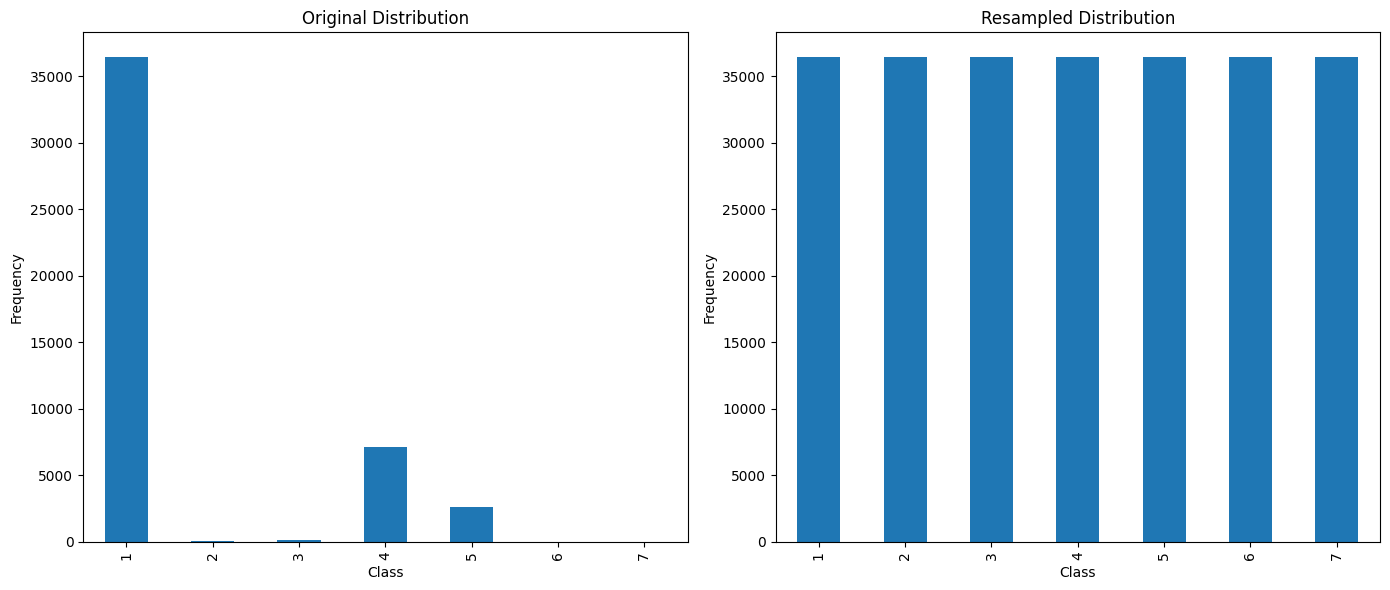


Class Weights (After Resampling):
{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [6]:
# Rebalance with SMOTE
X_resampled, y_resampled = apply_svmsmote_with_limit(X, y)

# Print resampled class distribution
print("\nResampled Class Distribution:")
print(pd.Series(y_resampled).value_counts())

# Visualize original and resampled distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
y.value_counts().sort_index().plot(kind='bar', ax=ax[0], title="Original Distribution")
pd.Series(y_resampled).value_counts().sort_index().plot(kind='bar', ax=ax[1], title="Resampled Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optionally calculate class weights
class_weights = calculate_class_weights(y_resampled)
print("\nClass Weights (After Resampling):")
print(class_weights)


In [7]:
# Combine resampled features and labels into a single DataFrame
resampled_data = pd.concat([X_resampled, y_resampled.rename('label')], axis=1)

# Save the resampled data to a CSV file
resampled_data.to_csv("resampled_data.csv", index=False)

print("Resampled data has been saved to 'resampled_data.csv'")


Resampled data has been saved to 'resampled_data.csv'


In [ ]:
# Load the dataset
dataset_path = "kdd_train.csv"
data = pd.read_csv(dataset_path)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Apply the function
X_resampled, y_resampled = apply_smote_after_downsampling(X, y)

# Print original and resampled class distributions
print("Original Class Distribution:")
print(y.value_counts())

print("\nResampled Class Distribution:")
print(pd.Series(y_resampled).value_counts())


Original Class Distribution:
label
normal.             778224
satan.               12714
ipsweep.              9985
portsweep.            8330
nmap.                 1853
back.                 1762
warezclient.           816
teardrop.              783
pod.                   211
guess_passwd.           42
buffer_overflow.        24
land.                   17
warezmaster.            16
imap.                   10
rootkit.                 8
loadmodule.              7
multihop.                6
ftp_write.               6
phf.                     2
perl.                    2
spy.                     2
Name: count, dtype: int64

Resampled Class Distribution:
label
satan.              12714
guess_passwd.       12714
spy.                12714
perl.               12714
ftp_write.          12714
imap.               12714
land.               12714
multihop.           12714
phf.                12714
loadmodule.         12714
warezmaster.        12714
portsweep.          12714
rootkit.            127